In [66]:
import pandas as pd
import re
import seaborn as sns
import numpy as np

In [97]:
EPS = 1e-8

## Data Loading

Dataset : https://archive.ics.uci.edu/ml/datasets/Statlog+%28Heart%29

In [208]:
columns ='''age
sex
chest_pain_type
resting_blood_pressure
serum_cholesterol
fasting_blood_sugar
resting_ecg
max_heart_rate
exercise_induced_angina
oldpeak
peak_exercise_slope
major_vessels
thal'''.split()

In [209]:
data = pd.read_csv('heart.data', header=None, sep=' ')

x = data.iloc[:, :-1]
x.columns = columns

y = data.iloc[:, -1]
y = y.map({2 : 1, 1: 0})

## Date preprocessing

In [210]:
bsize = 10
min_b = np.ceil(x['age'].min() / bsize) * bsize
max_b = np.floor(x['age'].max() / bsize) * bsize
bc = int(np.round((max_b - min_b) / bsize)) + 1
bins = np.linspace(min_b, max_b, bc)

In [211]:
def digitize(x, bsize, return_bins=False):
    min_b = np.ceil(np.min(x) / bsize) * bsize
    max_b = np.floor(np.max(x) / bsize) * bsize
    bc = int(np.round((max_b - min_b) / bsize)) + 1
    bins = np.linspace(min_b, max_b, bc)
    
    new_x = np.digitize(x, bins)
    
    if return_bins:
        return new_x, bins
    
    return new_x

In [212]:
def tobinary(x, return_labels=False):
    labels = {f : i for i, f in enumerate(set(x))}
    res = np.zeros((len(x), len(labels)), dtype=np.int64)
    for i, e in enumerate(x):
        res[i, labels[e]] = 1
    
    if return_labels:
        labels = sorted(labels.items(), key=lambda x: x[1])
        labels = [e[0] for e in labels]
        return res, labels
    return res

Plot numeric features' distribution to determine binsize

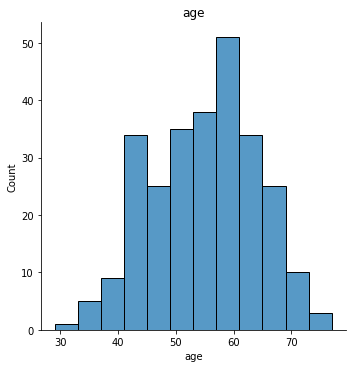

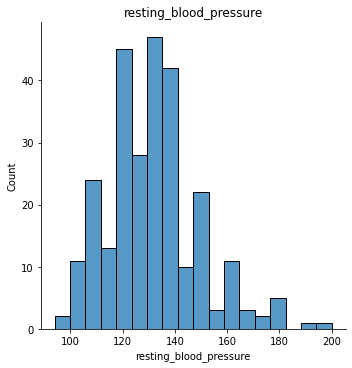

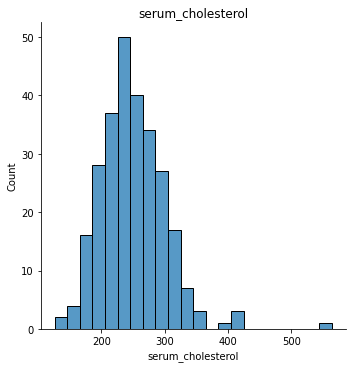

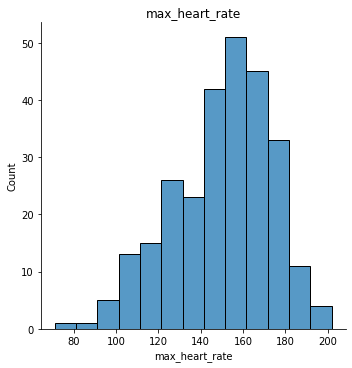

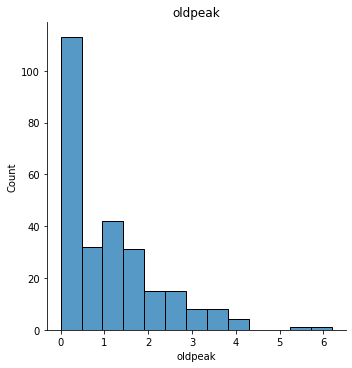

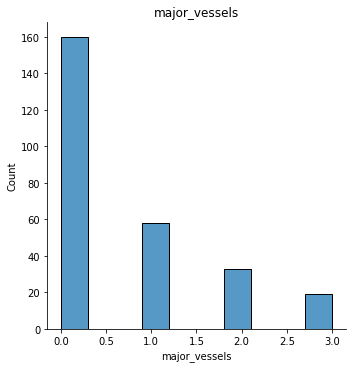

In [213]:
for i in [1,4,5,8,10,12]:
    f = columns[i-1]
    sns.displot(x[f]).set(title=f)

Convert numeric features to categorical

In [214]:
features2digitize = [
    ('age', 10),
    ('resting_blood_pressure', 20),
    ('serum_cholesterol', 100),
    ('max_heart_rate', 20),
    ('oldpeak', 1),
    ('major_vessels', 1)
]
digitized_features_bins = []

for f, bsize in features2digitize:
    x[f], t = digitize(x[f], bsize, return_bins=True)
    digitized_features_bins.append(t)

x = x.astype(int)

In [727]:
t = [(e[0], bins) for bins, e in zip(digitized_features_bins, features2digitize)]

In [732]:
print(*[f'{e[0]}\t{list(e[1])}' for e in t], sep='\n')

age	[30.0, 40.0, 50.0, 60.0, 70.0]
resting_blood_pressure	[100.0, 120.0, 140.0, 160.0, 180.0, 200.0]
serum_cholesterol	[200.0, 300.0, 400.0, 500.0]
max_heart_rate	[80.0, 100.0, 120.0, 140.0, 160.0, 180.0, 200.0]
oldpeak	[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
major_vessels	[0.0, 1.0, 2.0, 3.0]


Binarize categorical features

In [215]:
features2binarize = [f for f, items in x.iteritems() if set(items) != {0, 1}]

for f in features2binarize:
    values, labels = tobinary(x[f], return_labels=True)
    x = x.drop(f, axis=1)
    labels = [f'{f}_{e}' for e in labels]
    values = pd.DataFrame(values, columns=labels, index=x.index)
    x = pd.concat([x, values], axis=1)

In [733]:
x

,sex,fasting_blood_sugar,exercise_induced_angina,age_0,age_1,age_2,age_3,age_4,age_5,chest_pain_type_1,...,peak_exercise_slope_1,peak_exercise_slope_2,peak_exercise_slope_3,major_vessels_1,major_vessels_2,major_vessels_3,major_vessels_4,thal_3,thal_6,thal_7
0,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,1,1,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
2,1,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
3,1,0,1,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
4,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,1,1,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
266,1,0,0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
267,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
268,1,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0


## Classification

### Setup

In [670]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [240]:
x_train = np.array(x)
y_train = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1)

### Metrics

In [686]:
def tp(true, preds):
    m = confusion_matrix(true, preds)
    return m[1][1]

In [687]:
def tn(true, preds):
    m = confusion_matrix(true, preds)
    return m[0][0]

In [688]:
def fp(true, preds):
    m = confusion_matrix(true, preds)
    return m[0][1]

In [689]:
def fn(true, preds):
    m = confusion_matrix(true, preds)
    return m[1][0]

In [699]:
def tpr(true, preds):
    m = confusion_matrix(true, preds)
    return m[1][1] / (m[1][1] + m[1][0])

In [700]:
def tnr(true, preds):
    m = confusion_matrix(true, preds)
    return m[0][0] / (m[0][0] + m[0][1])

In [ ]:
def npv(true, preds):
    m = confusion_matrix(true, preds)
    return m[0][0] / (m[0][0] + m[1][0])

In [706]:
def fpr(true, preds):
    return 1 - tnr(true, preds)

In [707]:
def fdr(true, preds):
    m = confusion_matrix(true, preds)
    return m[0][1] / (m[0][1] + m[1][1])

In [713]:
def get_scores(true, preds):
    metrics = [
        ('TP', tp),
        ('TN', tn),
        ('FP', fp),
        ('FN', fn),
        ('TPR', tpr),
        ('TNR', tnr),
        ('NPV', npv),
        ('FPR', fpr),
        ('FDR', fdr),
        ('Accurancy', accuracy_score),
        ('Precision', precision_score),
        ('Recall', recall_score),
        ('f1', f1_score)
    ]
    
    res = [(e[0], e[1](true, preds)) for e in metrics]
    return res

### Naive bayes

In [714]:
nb = GaussianNB()
nb.fit(x_train, y_train)

preds = nb.predict(x_test)
nb_scores = get_scores(y_test, preds)

In [715]:
nb_scores

[('TP', 10),
 ('TN', 13),
 ('FP', 2),
 ('FN', 2),
 ('TPR', 0.8333333333333334),
 ('TNR', 0.8666666666666667),
 ('NPV', 0.8666666666666667),
 ('FPR', 0.1333333333333333),
 ('FDR', 0.16666666666666666),
 ('Accurancy', 0.8518518518518519),
 ('Precision', 0.8333333333333334),
 ('Recall', 0.8333333333333334),
 ('f1', 0.8333333333333334)]

### FCA lazy classifier

In [716]:
def feature_intersection(a, b):
    return np.where((a==1) & (b==1))[0]

In [717]:
def has_f_subset(inds, objs):
    return np.all(np.take(objs, inds, axis=1), axis=1)

In [718]:
def collect_stat(tobj, objs, labels):
    pos_context = objs[labels==1]
    neg_context = objs[labels==0]
    
    stat = []
    for label in [0, 1]:
        stat.append([])
        pos_context = objs[labels==label]
        neg_context = objs[labels!=label]
        
        for obj in pos_context:
            f_intr = feature_intersection(tobj, obj)
            mask = has_f_subset(f_intr, neg_context)
            cntr_exmpls = neg_context[mask]

            stat[-1].append((
                len(f_intr),
                len(cntr_exmpls),
                f_intr, cntr_exmpls, 
            ))
            
    return stat

In [719]:
def most_fit_top1(stat, default=1):
    stat = [sorted(e, key=lambda x: (x[1], 1/ (x[0]+1)))
            for e in stat]

    for n, p in zip(*stat):
        if p[1] < n[1]:
            return 1
        if p[1] > n[1]:
            return 0

        if p[0] > n[0]:
            return 1
        if p[0] < n[0]:
            return 0
    
    return default

In [720]:
def soft_mostfit_topk(stat, top_k=10):
    stat = [sorted(e, key=lambda x: (x[1], 1 / (x[0]+1)))
            for e in stat]
    
    scores = [np.mean([e[0] / (e[1]+1) for e in l[:top_k]]) for l in stat]

    return np.argmax(scores)

In [756]:
def fca_lz_cls(x, x_train, y_train, desicion_rule):
    stats = [collect_stat(e, x_train, y_train) for e in x]
    stats = [[[e[:2] for e in s] for s in r] for r in stats]
    
    return np.array([desicion_rule(e) for e in stats])

In [757]:
preds = fca_lz_cls(x_test, x_train, y_train, desicion_rule=most_fit_top1)

v1_scores = get_scores(y_test, preds)
v1_scores

[('TP', 11),
 ('TN', 12),
 ('FP', 3),
 ('FN', 1),
 ('TPR', 0.9166666666666666),
 ('TNR', 0.8),
 ('NPV', 0.9230769230769231),
 ('FPR', 0.19999999999999996),
 ('FDR', 0.21428571428571427),
 ('Accurancy', 0.8518518518518519),
 ('Precision', 0.7857142857142857),
 ('Recall', 0.9166666666666666),
 ('f1', 0.8461538461538461)]

In [758]:
preds = fca_lz_cls(x_test, x_train, y_train, desicion_rule=soft_mostfit_topk)

v2_1_scores = get_scores(y_test, preds)
v2_1_scores

[('TP', 10),
 ('TN', 14),
 ('FP', 1),
 ('FN', 2),
 ('TPR', 0.8333333333333334),
 ('TNR', 0.9333333333333333),
 ('NPV', 0.875),
 ('FPR', 0.06666666666666665),
 ('FDR', 0.09090909090909091),
 ('Accurancy', 0.8888888888888888),
 ('Precision', 0.9090909090909091),
 ('Recall', 0.8333333333333334),
 ('f1', 0.8695652173913043)]

In [759]:
preds = fca_lz_cls(x_test, x_train, y_train, desicion_rule=lambda x: soft_mostfit_topk(x, 3))

v2_2_scores = get_scores(y_test, preds)
v2_2_scores

[('TP', 10),
 ('TN', 13),
 ('FP', 2),
 ('FN', 2),
 ('TPR', 0.8333333333333334),
 ('TNR', 0.8666666666666667),
 ('NPV', 0.8666666666666667),
 ('FPR', 0.1333333333333333),
 ('FDR', 0.16666666666666666),
 ('Accurancy', 0.8518518518518519),
 ('Precision', 0.8333333333333334),
 ('Recall', 0.8333333333333334),
 ('f1', 0.8333333333333334)]

In [760]:
preds = fca_lz_cls(x_test, x_train, y_train, desicion_rule=lambda x: soft_mostfit_topk(x, 30))

v2_3_scores = get_scores(y_test, preds)
v2_3_scores

[('TP', 8),
 ('TN', 13),
 ('FP', 2),
 ('FN', 4),
 ('TPR', 0.6666666666666666),
 ('TNR', 0.8666666666666667),
 ('NPV', 0.7647058823529411),
 ('FPR', 0.1333333333333333),
 ('FDR', 0.2),
 ('Accurancy', 0.7777777777777778),
 ('Precision', 0.8),
 ('Recall', 0.6666666666666666),
 ('f1', 0.7272727272727272)]

In [763]:
print(*[f'{e[0][0]}\t{round(e[0][1],2)}\t{round(e[1][1],2)}\t{round(e[2][1],2)}\t{round(e[3][1],2)}\t{round(e[4][1],2)}'
    for e in zip(nb_scores, v1_scores, v2_1_scores, v2_2_scores, v2_3_scores)], sep='\n')

TP	10	11	10	10	8
TN	13	12	14	13	13
FP	2	3	1	2	2
FN	2	1	2	2	4
TPR	0.83	0.92	0.83	0.83	0.67
TNR	0.87	0.8	0.93	0.87	0.87
NPV	0.87	0.92	0.88	0.87	0.76
FPR	0.13	0.2	0.07	0.13	0.13
FDR	0.17	0.21	0.09	0.17	0.2
Accurancy	0.85	0.85	0.89	0.85	0.78
Precision	0.83	0.79	0.91	0.83	0.8
Recall	0.83	0.92	0.83	0.83	0.67
f1	0.83	0.85	0.87	0.83	0.73


In [762]:
len(nb_scores)

13